# 1 Carga de librerías

In [202]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as stats
from scipy.stats import ttest_ind
from scipy.stats import levene

# 2. Carga de dataset

In [203]:
# Uso de read_csv para leer los datos CSV, la "r" es para evitar los caracteres de escape
df = pd.read_csv(r'D:\Data analyst\datasets\games.csv')

In [204]:
#Uso de info para ver datos relevantes de los datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Comentarios:
- Nomenclatura inadecuada de las columnas, se procede a usar minúsculas y snake_case
- Solo presentamos 2 tipos de datos, objeto y flotantes, se indagará para hacer la transformación al dato correcto.
- Encontramos valores nulos, se indagará para tomar una buena decisión de su tratamiento.

In [205]:
#Uso de head para ver rápidamente los datos
df.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


# 3 Preparación de datos

### Modificación de columnas

In [206]:
#Ciclo for que itera sobre cada columna, aplicandole el método lower para volver a minúsculas
new_names = []
for old_names in df.columns:
    new_col_names = old_names.lower()
    new_names.append(new_col_names)

df.columns = new_names



df['year_of_release'] = pd.to_datetime(df['year_of_release']) #cambio de dato de str a datetime

df.insert(3,'date_of_release',df['year_of_release'].dt.normalize()) #creación de nueva columna solo con el año

df.drop(columns=['year_of_release'],inplace=True)

df.insert(4,'year',df['date_of_release'].dt.year) #creación de nueva columna solo con el año

df.columns

Index(['name', 'platform', 'date_of_release', 'genre', 'year', 'na_sales',
       'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score',
       'rating'],
      dtype='object')

### Evaluación y tratamiento de ausentes

In [207]:
#Suma de valores nulos
total_nans = df.isna().sum().sum()
print(f'El dataframe tiene \033[4m\033[1m{total_nans}\033[0m\033[0m valores nulos')

El dataframe tiene 22587 valores nulos


In [208]:
#Impresión de columnas con valores nulos
cols_with_nans = df.isna().any() #any evalua qué elemento cumple la condición de tener nulos con isna
list_cols_nans = df.loc[:, cols_with_nans].columns.to_list() 
'''
Selecciona las columnas con nulos --> df.loc[:,cols_with_nans],
Recupera solo el nombre de columna  --> .columns,
Vuelve a lista para imprimir --> .to_list()
'''
print(f'Columnas con valores nulos {list_cols_nans}')

Columnas con valores nulos ['name', 'date_of_release', 'genre', 'year', 'critic_score', 'user_score', 'rating']


In [209]:
#Eliminación de filas con nombre y género nulo para futuro análisis
df.dropna(subset=['name','genre'],inplace=True)
df.fillna({'year':0.0}, inplace=True)
df.isna().sum()

name                  0
platform              0
date_of_release     269
genre                 0
year                  0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating             6764
dtype: int64

#### Siglo de lanzamiento

In [210]:
#Filtro por año de lanzamiento, condición: Juegos lanzados antes del 2000 o siglo 21
century_20th_games = df[df['year'] < 2000.0].reset_index()
nans_20th = century_20th_games.isna().sum()
total_20th_nans = nans_20th.sum()
print(f'El dataframe de los juegos lanzados antes del 2000 tiene \033[4m\033[1m{total_20th_nans}\033[0m\033[0m valores nulos, \nesto representa el {(total_20th_nans*100)/total_nans:.2f}% del total de nulos.')

El dataframe de los juegos lanzados antes del 2000 tiene 22308 valores nulos, 
esto representa el 98.76% del total de nulos.


In [211]:
#Filtro para encontrar los nulos de juegos lanzados en el siglo 21
century_21th_games = df[df['year'] >= 2000].reset_index()
total_21th_nans  = century_21th_games.isna().sum().sum()
print(f'El dataframe de los juegos lanzados en el siglo 21 tiene \033[4m\033[1m{total_21th_nans}\033[0m\033[0m valores nulos, \nesto representa el {(total_21th_nans*100)/total_nans:.2f}% del total de nulos.')

El dataframe de los juegos lanzados en el siglo 21 tiene 0 valores nulos, 
esto representa el 0.00% del total de nulos.


**Comentario:**

Analizando los nulos obtenidos, observamos que son juegos del siglo 20, lanzados antes del 2000. Vemos que los nulos relevantes son respecto a la crítica, crítica de usuarios y la clasificación.

**Decisión de nulos:**

Los nulos de la columna de nombre se ha optado por sustituir por "unknown" y los de año de lanzamiento  she han dejado para mantener el tipo de dato.

Dependiendo el análisis, se podrá tomar en cuenta los datos de crítica profesional, crítica de usuario y clasificación. Lista de casos donde se usarán:

- Cálculos de jugadores en las diferentes regiones.
- Análisis por género, año de lanzamiento y plataforma.

Casos en donde no se podrá considerar estos datos:

- Cálculos por rating, puntuación y por puntuación de usuarios.

De momento se ha decidido **<u>no eliminar</u>** estos nulos.

In [212]:
#Creación de listas con valores únicos
platforms = df['platform'].unique().tolist()
years = df['year'].unique().tolist()
genres = df['genre'].unique().tolist()

##### Plataforma

In [213]:
#Ciclo for que indaga los nulos por plataforma
platforms_nulls = []
for platform in platforms:
    platform_filter = df[df['platform'].isin([platform])]
    platforms_nans = platform_filter.isna().sum().sum()
    platforms_nulls.append(platforms_nans)

platform_data = list(zip(platforms, platforms_nulls))
df_platform = pd.DataFrame(platform_data,columns=['platform','nans'])
df_platform.head()

,platform,nans
0,Wii,1407
1,NES,294
2,GB,295
3,DS,3221
4,X360,798


##### Año

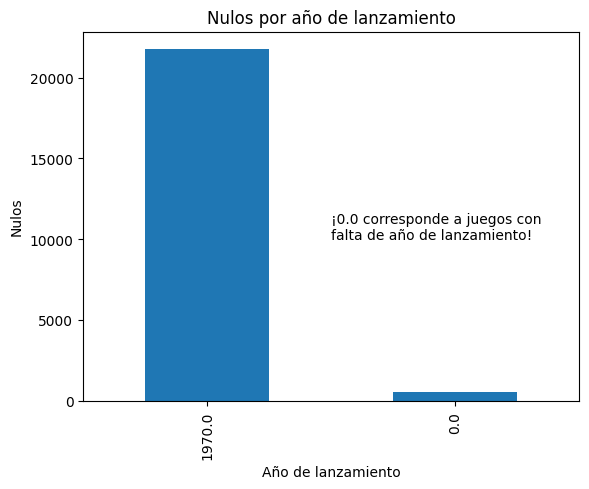

In [214]:
#Ciclo for que indaga los nulos por año
year_nulls = []
for year in years:
    year_filter = df[df['year'].isin([year])]
    year_nans = year_filter.isna().sum().sum()
    year_nulls.append(year_nans)
    
year_data = list(zip(years, year_nulls))
df_year = pd.DataFrame(year_data,columns=['year','nans'])

df_year.plot.bar(x='year', y='nans', legend=False)
plt.xlabel('Año de lanzamiento')
plt.ylabel('Nulos')
plt.title('Nulos por año de lanzamiento')
plt.text(0.5,10000,"¡0.0 corresponde a juegos con \nfalta de año de lanzamiento!")
plt.show()

##### Género

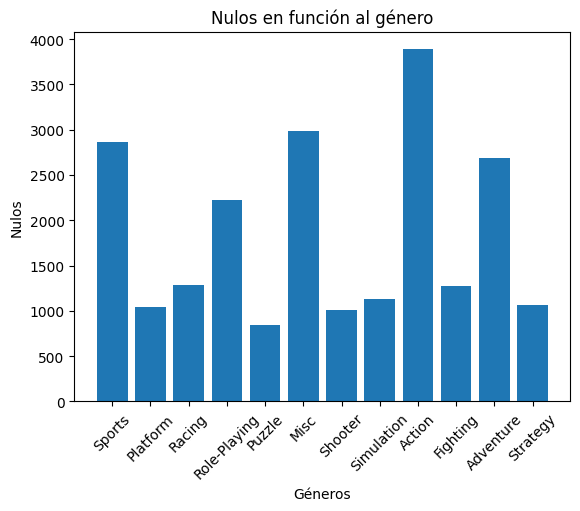

In [215]:
#Ciclo for que indaga los nulos por genero
genre_nulls = []
for genre in genres:
    genre_filter = df[df['genre'].isin([genre])]
    genre_nans = genre_filter.isna().sum().sum()
    genre_nulls.append(genre_nans)
    
genre_data = list(zip(genres, genre_nulls))
df_genre = pd.DataFrame(genre_data,columns=['genre','nans'])

plt.bar(df_genre['genre'],df_genre['nans'])
plt.title('Nulos en función al género')
plt.xticks(rotation=45)
plt.xlabel('Géneros')
plt.ylabel('Nulos')
plt.show()

**Decisión sobre nulos**

Hemos descubierto que no depende de la plataforma, género. Los nulos dependen del año de lanzamiento y/o alguna otra variable.

Vemos que el año 1970 tiene 21 mil nulos.

De momento, se ha decidido **<u>no eliminar</u>** estos nulos.

#### Ventas por Región

In [216]:
eu_sales = df[(df['eu_sales']==0.0) & (df['na_sales']>0.0) & (df['jp_sales']>0.0) & (df['other_sales']>0.0)].reset_index()
total_eu_nans = eu_sales.isna().sum().sum()
total_eu_nans

np.int64(137)

In [217]:
na_sales = df[(df['na_sales']==0.0) & (df['eu_sales']>0.0) & (df['jp_sales']>0.0) & (df['other_sales']>0.0)].reset_index()
total_na_nans = na_sales.isna().sum().sum()
total_na_nans

np.int64(68)

In [218]:
jp_sales = df[(df['jp_sales']==0.0) & (df['eu_sales']>0.0) & (df['na_sales']>0.0) & (df['other_sales']>0.0)].reset_index()
total_jp_nans = jp_sales.isna().sum().sum()
total_jp_nans

np.int64(4597)

In [219]:
other_sales = df[(df['other_sales']==0.0) & (df['eu_sales']>0.0) & (df['jp_sales']>0.0) & (df['na_sales']>0.0)].reset_index()
total_other_nans = other_sales.isna().sum().sum()
total_other_nans

np.int64(79)

**Comentario**

Hemos descubierto que los juegos que no tuvieron ventas en japón tienen una gran cantidad de nulos, aun así, el año de lanzamiento parece ser un factor más determinante en la cantidad de nulos.

In [220]:
all_sales = df[(df['other_sales']==0.0) | (df['eu_sales']==0.0) | (df['jp_sales']==0.0) | (df['na_sales']==0.0)].reset_index()
total_all_nans = all_sales.isna().sum().sum()
total_all_nans

np.int64(20421)

**Comentario**

Al parecer, los valores nulos dependen de las ventas y el año de lanzamiento, éstos pudieron ser por falta de ventas en una o más regiones antesl del 2000.

Aquí podríamos deducir que antes del 2000 no había una cultura de jugar videojuegos, por lo que no había ventas.

### Cálculo de ventas

In [221]:
df.insert(5,'total_sales',df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales'])
df.head()

,name,platform,date_of_release,genre,year,total_sales,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,1970-01-01,Sports,1970.0,82.54,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1970-01-01,Platform,1970.0,40.24,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,1970-01-01,Racing,1970.0,35.52,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,1970-01-01,Sports,1970.0,32.77,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1970-01-01,Role-Playing,1970.0,31.38,11.27,8.89,10.22,1.00,NaN,NaN,NaN
